# Modelos seq2seq, Atención y Transformers

## Parte 1: Modelos seq2seq clásicos

Un modelo **Sequence-to-Sequence (Seq2Seq)** clásico está diseñado para transformar una **secuencia de entrada** en una **secuencia de salida**, como por ejemplo traducir una oración en español a inglés o generar un resumen de un texto. Este tipo de arquitectura se compone de dos bloques principales:
<br><br><br>

**Codificador (Encoder)**

El codificador recibe una secuencia de entrada $\mathbf{x} = (x_1, x_2, \dots, x_T)$ y produce una **representación vectorial fija** que resume la información de la secuencia. Esto se hace usando una red neuronal recurrente (RNN), como una GRU o LSTM:

$$
\mathbf{h}_t = \text{RNN}(\mathbf{x}_t, \mathbf{h}_{t-1})
$$

Al final, se obtiene un **estado oculto final** $\mathbf{h}_T$ que representa toda la secuencia de entrada.
<br><br><br>

**Decodificador (Decoder)**

El decodificador es también una RNN que toma como entrada el estado final del codificador y genera los elementos de la secuencia de salida $\mathbf{y} = (y_1, y_2, \dots, y_L)$ uno por uno:

$$
\mathbf{s}_t = \text{RNN}(y_{t-1}, \mathbf{s}_{t-1}) \\
\hat{y}_t = \text{softmax}(W \mathbf{s}_t + b)
$$

Donde:

- $\mathbf{s}_0$ se inicializa con el estado oculto final del codificador: $\mathbf{s}_0 = \mathbf{h}_T$,
- $y_{t-1}$ es la palabra anterior generada (o la verdadera, si se usa *teacher forcing*),
- $\hat{y}_t$ es la distribución de probabilidad sobre el vocabulario para la siguiente palabra.
<br><br><br>

**Función de pérdida**

El modelo se entrena minimizando el **error de entropía cruzada** entre la secuencia generada y la secuencia objetivo:

$$
\mathcal{L} = -\sum_{t=1}^L \log p(y_t \mid y_{<t}, \mathbf{x})
$$

<br><br><br>

Este modelo **condensa toda la entrada en un solo vector** $\mathbf{h}_T$, lo cual puede ser problemático para secuencias largas. Esta limitación es una de las principales motivaciones para introducir **mecanismos de atención**, que veremos en la siguiente sección.


In [1]:
# Importamos librerías necesarias

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
# Tokens especiales
TOKENS = ["<pad>", "<sos>", "<eos>", "<unk>"]

Padding:

Oración 1: "Hola mundo"                                    (2 tokens)

Oración 2: "Me gusta el aprendizaje automático"           (5 tokens)

Oración 3: "Esta es una oración más larga con más palabras" (9 tokens) <br><br>

Oración 1: "Hola mundo `<pad>` `<pad>` `<pad>` `<pad>` `<pad>` `<pad>` `<pad>`"           (9 tokens)

Oración 2: "Me gusta el aprendizaje automático `<pad>` `<pad>` `<pad>` `<pad>`"     (9 tokens)  

Oración 3: "Esta es una oración más larga con más palabras"                 (9 tokens)

In [3]:
datos = [
    ("Hoy es un día soleado en Medellín y muchas personas están saliendo a caminar.", "Día soleado en Medellín."),
    ("La reunión de trabajo fue reprogramada para el próximo lunes a las 10 de la mañana.", "Reunión reprogramada al lunes."),
    ("El nuevo centro comercial abrirá sus puertas este fin de semana con grandes promociones.", "Centro comercial abre este fin."),
    ("Se espera que el tráfico aumente en la ciudad por el concierto de esta noche.", "Aumento de tráfico por concierto."),
    ("Las autoridades recomiendan evitar el uso de vehículos por trabajos de mantenimiento.", "Evitar vehículos por mantenimiento."),
    ("El equipo local ganó el campeonato en un partido emocionante que terminó 3 a 2.", "Equipo local gana campeonato."),
    ("La temperatura bajará considerablemente durante los próximos días según el pronóstico.", "Pronostican baja de temperatura."),
    ("El gobierno anunció nuevas medidas para apoyar a los pequeños negocios.", "Nuevas medidas para negocios."),
    ("El servicio de transporte estará suspendido temporalmente por labores técnicas.", "Transporte suspendido temporalmente."),
    ("Se registró un temblor leve esta madrugada sin reportes de daños.", "Temblor leve sin daños."),
    ("Miles de personas asistieron al desfile cultural en el centro histórico.", "Alta asistencia al desfile cultural."),
    ("La biblioteca municipal ofrecerá talleres gratuitos durante el mes de julio.", "Talleres gratuitos en biblioteca."),
    ("Los estudiantes presentaron sus proyectos finales en la feria de ciencia escolar.", "Proyectos presentados en feria escolar."),
    ("La película más esperada del año se estrenará este viernes en todos los cines.", "Estreno de película este viernes."),
    ("Se realizó una jornada de vacunación en diferentes barrios de la ciudad.", "Jornada de vacunación realizada."),
    ("La lluvia ocasionó demoras en varios vuelos nacionales.", "Demoras en vuelos por lluvia."),
    ("La empresa anunció un aumento de salario para todos sus empleados.", "Aumento salarial anunciado."),
    ("La policía capturó a los responsables del robo ocurrido anoche.", "Capturan responsables de robo."),
    ("El parque natural fue reabierto al público con nuevas rutas ecológicas.", "Parque natural reabre al público."),
    ("Se celebró el día internacional del medio ambiente con actividades educativas.", "Celebran día del medio ambiente."),
    ("El presidente dio un discurso sobre la economía colombiana esta mañana.", "Discurso del presidente sobre economía."),
    ("Los bomberos controlaron un incendio en una fábrica del norte de la ciudad.", "Bomberos controlan incendio en fábrica."),
    ("La universidad anunció nuevas becas para estudiantes de bajos recursos.", "Nuevas becas en la universidad."),
    ("Una exposición de arte contemporáneo abrió hoy en el museo central.", "Exposición de arte abre hoy."),
    ("El ciclón tropical causó daños en varias viviendas del litoral pacífico.", "Ciclón causa daños en litoral."),
    ("Vecinos del barrio San José organizaron una jornada de limpieza.", "Vecinos realizan limpieza en San José."),
    ("El sistema de salud implementará un nuevo protocolo para emergencias.", "Nuevo protocolo de emergencias."),
    ("Se realizó una protesta pacífica frente al congreso nacional.", "Protesta pacífica frente al congreso."),
    ("La ciudad instalará nuevas cámaras de seguridad en zonas comerciales.", "Nuevas cámaras en zonas comerciales."),
    ("Una banda musical local lanzó su nuevo álbum en plataformas digitales.", "Banda local lanza nuevo álbum."),
    ("El zoológico recibió a una pareja de pandas gigantes desde China.", "Pandas gigantes llegan al zoológico."),
    ("Autoridades sanitarias alertan sobre un brote de dengue en la región.", "Alerta por brote de dengue."),
    ("Una feria del libro se llevará a cabo este fin de semana en el parque principal.", "Feria del libro este fin de semana."),
    ("El festival gastronómico atrajo a cientos de personas este sábado.", "Festival gastronómico atrae multitudes."),
    ("Un nuevo puente fue inaugurado para mejorar la movilidad entre comunas.", "Inauguran puente para movilidad."),
    ("Se abrirá una convocatoria para jóvenes emprendedores tecnológicos.", "Convocatoria para emprendedores tech."),
    ("El hospital general habilitó más camas UCI por aumento de casos.", "Hospital habilita más camas UCI."),
    ("El índice de desempleo bajó ligeramente en el último trimestre.", "Desempleo baja en último trimestre."),
    ("Una avioneta tuvo que aterrizar de emergencia por fallas técnicas.", "Aterrizaje de emergencia por fallas.")
]


In [4]:
def tokenizar(texto):
    """
    Tokeniza un texto en minúsculas, eliminando espacios iniciales y finales.

    Args:
        texto (str): Texto de entrada.

    Returns:
        list: Lista de tokens (palabras).
    """
    return texto.lower().strip().split()

def construir_vocabulario(pares):
    """
    Construye un vocabulario a partir de pares de (texto, resumen).

    Args:
        pares (list): Lista de tuplas (texto, resumen).

    Returns:
        tuple: (diccionario token->índice, diccionario índice->token)
    """
    vocab = {tok: i for i, tok in enumerate(TOKENS)}
    idx = len(vocab)
    for texto, resumen in pares:
        for palabra in tokenizar(texto) + tokenizar(resumen):
            if palabra not in vocab:
                vocab[palabra] = idx
                idx += 1
    inv_vocab = {i: tok for tok, i in vocab.items()}
    return vocab, inv_vocab

vocab, inv_vocab = construir_vocabulario(datos)

In [5]:
class DatosResumen(Dataset):
    """
    Dataset personalizado para pares de (texto, resumen) tokenizados.
    """
    def __init__(self, pares):
        """
        Inicializa el dataset con los pares de datos.

        Args:
            pares (list): Lista de tuplas (texto, resumen).
        """
        self.pares = pares

    def __len__(self):
        """
        Devuelve el número de pares en el dataset.

        Returns:
            int: Número de pares.
        """
        return len(self.pares)

    def __getitem__(self, idx):
        """
        Obtiene el par tokenizado en la posición dada.

        Args:
            idx (int): Índice del par.

        Returns:
            tuple: (tokens del texto, tokens del resumen)
        """
        texto, resumen = self.pares[idx]
        return tokenizar(texto), tokenizar(resumen)

def a_tensor(tokens, vocab):
    """
    Convierte una lista de tokens a un tensor de índices según el vocabulario.

    Args:
        tokens (list): Lista de tokens.
        vocab (dict): Diccionario token->índice.

    Returns:
        torch.Tensor: Tensor de índices.
    """
    return torch.tensor([vocab.get(tok, vocab['<unk>']) for tok in tokens], dtype=torch.long)

def collate(batch):
    """
    Función de colación para DataLoader: convierte batch de pares en tensores con padding.

    Args:
        batch (list): Lista de tuplas (entrada, salida).

    Returns:
        tuple: (tensor de entradas, tensor de salidas)
    """
    entradas, salidas = [], []
    for entrada, salida in batch:
        entrada = a_tensor(entrada + ["<eos>"], vocab)
        salida = a_tensor(["<sos>"] + salida + ["<eos>"], vocab)
        entradas.append(entrada)
        salidas.append(salida)
    entradas = nn.utils.rnn.pad_sequence(entradas, padding_value=vocab["<pad>"])
    salidas = nn.utils.rnn.pad_sequence(salidas, padding_value=vocab["<pad>"])
    return entradas, salidas

In [6]:
class Codificador(nn.Module):
    """
    Codificador basado en GRU para modelos seq2seq.
    """
    def __init__(self, vocab_size, emb_dim, hidden_dim):
        """
        Inicializa el codificador.

        Args:
            vocab_size (int): Tamaño del vocabulario.
            emb_dim (int): Dimensión del embedding.
            hidden_dim (int): Dimensión del estado oculto.
        """
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.rnn = nn.GRU(emb_dim, hidden_dim)

    def forward(self, src):
        """
        Procesa la secuencia de entrada.

        Args:
            src (torch.Tensor): Secuencia de entrada.

        Returns:
            torch.Tensor: Estado oculto final.
        """
        emb = self.emb(src)
        _, hidden = self.rnn(emb)
        return hidden

class DecodificadorSimple(nn.Module):
    """
    Decodificador simple basado en GRU para modelos seq2seq.
    """
    def __init__(self, vocab_size, emb_dim, hidden_dim):
        """
        Inicializa el decodificador.

        Args:
            vocab_size (int): Tamaño del vocabulario.
            emb_dim (int): Dimensión del embedding.
            hidden_dim (int): Dimensión del estado oculto.
        """
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.rnn = nn.GRU(emb_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input, hidden):
        """
        Procesa un paso de decodificación.

        Args:
            input (torch.Tensor): Token de entrada.
            hidden (torch.Tensor): Estado oculto previo.

        Returns:
            tuple: (predicción de salida, nuevo estado oculto)
        """
        emb = self.emb(input.unsqueeze(0))
        output, hidden = self.rnn(emb, hidden)
        pred = self.fc(output.squeeze(0))
        return pred, hidden

class Seq2SeqSimple(nn.Module):
    """
    Modelo seq2seq simple con codificador y decodificador.
    """
    def __init__(self, encoder, decoder):
        """
        Inicializa el modelo seq2seq.

        Args:
            encoder (nn.Module): Codificador.
            decoder (nn.Module): Decodificador.
        """
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, tgt, teacher_forcing=0.5):
        """
        Ejecuta la pasada hacia adelante del modelo seq2seq.

        Args:
            src (torch.Tensor): Secuencia de entrada.
            tgt (torch.Tensor): Secuencia objetivo.
            teacher_forcing (float): Proporción de teacher forcing.

        Returns:
            torch.Tensor: Salidas del decodificador.
        """
        tgt_len, batch_size = tgt.shape
        vocab_size = self.decoder.fc.out_features
        outputs = torch.zeros(tgt_len, batch_size, vocab_size)

        hidden = self.encoder(src)
        input = tgt[0, :]

        for t in range(1, tgt_len):
            output, hidden = self.decoder(input, hidden)
            outputs[t] = output
            top1 = output.argmax(1)
            input = tgt[t] if torch.rand(1).item() < teacher_forcing else top1

        return outputs

In [7]:
modelo = Seq2SeqSimple(
    Codificador(len(vocab), 32, 64),
    DecodificadorSimple(len(vocab), 32, 64)
)

opt = optim.Adam(modelo.parameters(), lr=0.01)
criterio = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"])

dataloader = DataLoader(DatosResumen(datos), batch_size=2, shuffle=True, collate_fn=collate)

modelo.train()
for epoca in range(10):
    total = 0
    for src, tgt in dataloader:
        src, tgt = src, tgt
        salida = modelo(src, tgt)
        salida = salida[1:].reshape(-1, salida.shape[-1])
        tgt = tgt[1:].reshape(-1)
        loss = criterio(salida, tgt)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total += loss.item()
    print(f"\nÉpoca {epoca+1}, Pérdida: {total/len(dataloader):.4f}")


Época 1, Pérdida: 5.4090

Época 2, Pérdida: 4.3242

Época 3, Pérdida: 3.7034

Época 4, Pérdida: 3.1073

Época 5, Pérdida: 2.4715

Época 6, Pérdida: 1.7409

Época 7, Pérdida: 1.1241

Época 8, Pérdida: 0.5920

Época 9, Pérdida: 0.3744

Época 10, Pérdida: 0.1630


In [8]:

def resumir(texto):
    """
    Genera un resumen para el texto dado usando el modelo entrenado.

    Args:
        texto (str): Texto de entrada.

    Returns:
        str: Resumen generado.
    """
    modelo.eval()
    tokens = tokenizar(texto) + ["<eos>"]
    src_tensor = a_tensor(tokens, vocab).unsqueeze(1)
    hidden = modelo.encoder(src_tensor)

    input = torch.tensor([vocab["<sos>"]])
    resultado = []

    for _ in range(10):
        output, hidden = modelo.decoder(input, hidden)
        top1 = output.argmax(1).item()
        if inv_vocab[top1] == "<eos>":
            break
        resultado.append(inv_vocab[top1])
        input = torch.tensor([top1])

    return " ".join(resultado)

# Ejemplo:
print("\nResumen:", resumir("El presidente fue a la UCI el lunes en su carro presidencial."))



Resumen: parque natural reabre al público.


## Parte 2: Mecanismo de Atención

El mecanismo de **atención** fue introducido para superar una limitación importante de los modelos Seq2Seq clásicos: la compresión de toda la secuencia de entrada en un único vector. Con atención, el decodificador puede **mirar directamente a todas las salidas del codificador** y enfocarse en las partes más relevantes en cada paso de decodificación.
<br><br><br>

En lugar de usar solo el último estado oculto del codificador, la atención permite al decodificador hacer una **combinación ponderada** de **todos los estados ocultos** del codificador:

$$
\mathbf{c}_t = \sum_{i=1}^{T} \alpha_{t,i} \, \mathbf{h}_i
$$

Donde:

- $\mathbf{c}_t$ es el **vector de contexto** en el paso $t$ del decodificador,
- $\alpha_{t,i}$ es el **peso de atención** asignado al estado oculto $i$ del codificador.

<br><br><br>

Los pesos de atención $\alpha_{t,i}$ se obtienen comparando el estado actual del decodificador $\mathbf{s}_t$ con cada estado del codificador $\mathbf{h}_i$ mediante una función de puntuación (*score function*):

$$
e_{t,i} = \text{score}(\mathbf{s}_t, \mathbf{h}_i) \quad \Rightarrow \quad \alpha_{t,i} = \frac{\exp(e_{t,i})}{\sum_{j=1}^{T} \exp(e_{t,j})}
$$

Ejemplos de funciones de puntuación:

- Producto escalar: $e_{t,i} = \mathbf{s}_t^\top \mathbf{h}_i$
- General (con parámetros): $e_{t,i} = \mathbf{s}_t^\top W \mathbf{h}_i$
- Aditiva (*Bahdanau*): $e_{t,i} = \mathbf{v}^\top \tanh(W_1 \mathbf{h}_i + W_2 \mathbf{s}_t)$

<br><br><br>

Nos permite usar **secuencias largas** y mejora la interpretación: los pesos $\alpha_{t,i}$ indican **en qué parte del input se fijó el modelo**.
<br><br><br>

**Auto-atención**

El mecanismo de **auto-atención** (o *self-attention*) es una generalización del mecanismo anterior. En lugar de calcular atención entre la entrada y la salida, **cada elemento de una secuencia se compara consigo mismo y con todos los demás elementos de la misma secuencia**.
<br><br><br>

**Intuición**

Para cada posición $i$ de la secuencia, se genera un nuevo vector como combinación de los demás:

$$
\text{Attention}(Q, K, V) = \text{softmax} \left( \frac{Q K^\top}{\sqrt{d_k}} \right) V
$$

Donde:

- $Q$ (queries), $K$ (keys) y $V$ (values) son matrices obtenidas de la entrada original mediante transformaciones lineales,
- $\frac{Q K^\top}{\sqrt{d_k}}$ calcula las puntuaciones de similitud escaladas,
- La función *softmax* convierte las puntuaciones en pesos de atención,
- El producto final con $V$ da la salida atencional.
<br><br><br>


| Mecanismo        | Entrada             | Atención sobre      | Uso principal                   |
|------------------|---------------------|----------------------|---------------------------------|
| Atención         | secuencia codificada | estados del encoder  | Seq2Seq con RNNs                |
| Auto-atención    | secuencia completa   | ella misma           | Transformers                    |


In [9]:
# Importamos librerías necesarias

import numpy as np
import matplotlib.pyplot as plt

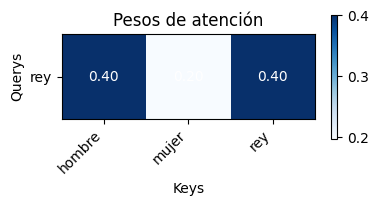

Resultado de la atención (context vector): [[20.]]


In [10]:
# Ponemos palabras en vectores arbitrarios. Además calculamos y visualizamos atención

queries = ["rey"]
words    = ["hombre", "mujer", "rey"]

q = np.array([[1.0, 0.0]])                    
k = np.array([[1.0, 0.0],                      
              [0.0, 1.0],                      
              [1.0, 1.0]])                     
v = np.array([[10], [20], [30]])               

def attention(query, key, value):
    """
    Calcula la atención escalar entre un query y un conjunto de keys y values.

    Args:
        query (np.ndarray): Vector de consulta (query).
        key (np.ndarray): Matriz de claves (keys).
        value (np.ndarray): Matriz de valores (values).

    Returns:
        tuple: (vector de contexto resultante, matriz de pesos de atención)
    """
    d_k = query.shape[-1]
    scores = np.dot(query, key.T) / np.sqrt(d_k)
    weights = np.exp(scores) / np.sum(np.exp(scores), axis=-1, keepdims=True)
    attended = np.dot(weights, value)
    return attended, weights

result, weights = attention(q, k, v) 

fig, ax = plt.subplots(figsize=(4,2))
im = ax.imshow(weights, cmap="Blues")

ax.set_xticks(np.arange(len(words)))
ax.set_xticklabels(words, rotation=45, ha="right")
ax.set_yticks(np.arange(len(queries)))
ax.set_yticklabels(queries)

for i in range(weights.shape[1]):
    ax.text(i, 0, f"{weights[0,i]:.2f}", ha="center", va="center", color="white")

ax.set_title("Pesos de atención")
ax.set_xlabel("Keys")
ax.set_ylabel("Querys")
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

print("Resultado de la atención (context vector):", result)


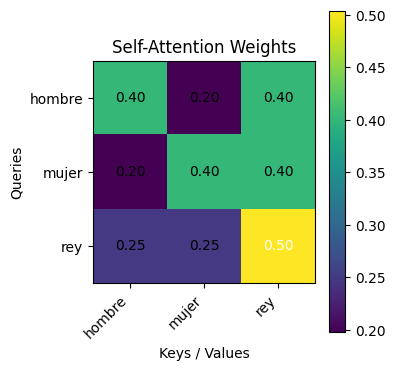

Context vectors shape: (3, 2)
Context matrix (cada fila es el nuevo embedding):
 [[0.802 0.599]
 [0.599 0.802]
 [0.752 0.752]]


In [11]:
# Ponemos palabras en vectores arbitrarios. Además calculamos y visualizamos auto-atención

X = np.array([
    [1.0, 0.0],   # "rey"
    [0.0, 1.0],   # "hombre"
    [1.0, 1.0],   # "mujer"
])  

def self_attention(X):
    """
    Calcula la auto-atención sobre una matriz de embeddings.

    Args:
        X (np.ndarray): Matriz de embeddings de entrada.

    Returns:
        tuple: (matriz de embeddings atendidos, matriz de pesos de atención)
    """
    d_k = X.shape[-1]
    scores = X.dot(X.T) / np.sqrt(d_k)
    exp = np.exp(scores)
    weights = exp / exp.sum(axis=1, keepdims=True)
    attended = weights.dot(X)
    return attended, weights

attended, W = self_attention(X)

fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(W, cmap="viridis")

ax.set_xticks(np.arange(len(words)))
ax.set_xticklabels(words, rotation=45, ha="right")
ax.set_yticks(np.arange(len(words)))
ax.set_yticklabels(words)

for i in range(len(words)):
    for j in range(len(words)):
        ax.text(j, i, f"{W[i,j]:.2f}", ha="center", va="center",
                color="white" if W[i,j]>0.5 else "black")

ax.set_title("Self-Attention Weights")
ax.set_xlabel("Keys / Values")
ax.set_ylabel("Queries")
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

print("Context vectors shape:", attended.shape)
print("Context matrix (cada fila es el nuevo embedding):\n", np.round(attended,3))


## Parte 3: Transformers

La **atención multi-cabeza** es un componente fundamental del Transformer. En lugar de aplicar una sola atención, se aplican múltiples atenciones en paralelo, cada una con sus propios parámetros de proyección.

<br><br><br>

**¿Por qué usar múltiples cabezas?**
<br><br><br>

Cada cabeza puede **capturar diferentes tipos de relaciones** entre palabras:

- Una puede enfocarse en la sintaxis,
- Otra en el significado semántico,
- Otra en relaciones de largo alcance, etc.

<br><br><br>

Para cada cabeza $i$, se proyectan las entradas $Q$, $K$ y $V$:

$$
\text{head}_i = \text{Attention}(Q W_i^Q, K W_i^K, V W_i^V)
$$

Luego, se concatenan todas las cabezas y se proyecta el resultado:

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h) W^O
$$

Donde:

- $W_i^Q$, $W_i^K$, $W_i^V$ son matrices de proyección por cabeza,
- $W^O$ es una matriz de proyección final.

<br><br><br>

El **Transformer** es un modelo basado únicamente en atención (sin RNNs ni CNNs) propuesto por Vaswani et al. (2017). Se compone de dos bloques principales: **codificador** y **decodificador**.
<br><br><br>

**Estructura general**

- **Codificador:** procesa la secuencia de entrada.
- **Decodificador:** genera la salida, un token a la vez, usando los resultados del codificador y auto-atención.
<br><br><br>

Cada bloque tiene múltiples capas que contienen:

1. **Capa de atención multi-cabeza**
2. **Red neuronal feedforward (FFN)**
3. **Normalización residual** (con *LayerNorm*)
4. **Dropout** para regularización

<br><br><br>

**Esquema de una capa del codificador**

```
Entrada →
        +--------------------------------+
        |  Auto-atención multi-cabeza   |
        +--------------------------------+
                        ↓
        +--------------------------------+
        | Red neuronal feedforward (FFN) |
        +--------------------------------+
                        ↓
                  Salida codificada
```

<br><br><br>

**Codificador vs Decodificador**
<br><br><br>

| Componente     | Codificador         | Decodificador                          |
|----------------|---------------------|----------------------------------------|
| Atención 1     | Auto-atención       | Auto-atención (con máscara causal)     |
| Atención 2     | –                   | Atención al codificador (cross-att.)   |
| FFN            | Sí                  | Sí                                     |
| Normalización  | Sí (residual + norm)| Sí (residual + norm)                   |

<br><br><br>

**Positional Encoding**

Ya que el Transformer no usa RNNs, se añaden **codificaciones posicionales** a los embeddings para indicar el orden de las palabras. 
<br><br><br>

Nos permite paralelizar el entrenamiento (no hay dependencias secuenciales), aprende dependencias de largo alcance mejor que los RNNs tradicionales, y ha sido la base de los modelos más potentes como BERT, GPT, T5, etc.
<br><br><br>

**Resumen final**:

| Modelo        | Principal mecanismo      | Ideal para...              |
|---------------|---------------------------|-----------------------------|
| Seq2Seq clásico | RNNs                     | Traducción, generación      |
| Con atención   | RNN + atención            | Traducción con contexto largo |
| Transformer    | Auto-atención + FFN       | Todo tipo de tareas de NLP  |



In [12]:
# Importamos librerías necesarias

import torch
import torch.nn.functional as F
import torch.nn as nn

In [13]:
# Definimos clases para la atención multi-cabeza, el bloque Transformer

class MultiHeadAttention(nn.Module):
    """
    Implementa la atención multi-cabeza para modelos tipo Transformer.

    Args:
        d_model (int): Dimensión del modelo.
        num_heads (int): Número de cabezas de atención.
    """
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, x):
        """
        Realiza la pasada hacia adelante de la atención multi-cabeza.

        Args:
            x (torch.Tensor): Tensor de entrada de forma (batch, secuencia, d_model).

        Returns:
            tuple: (tensor de salida, pesos de atención)
        """
        B, T, C = x.size()
        Q = self.W_q(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.d_k**0.5
        weights = F.softmax(scores, dim=-1)
        heads = torch.matmul(weights, V)
        concat = heads.transpose(1, 2).contiguous().view(B, T, C)
        return self.W_o(concat), weights
    
class TransformerBlock(nn.Module):
    """
    Implementa un bloque Transformer compuesto por atención multi-cabeza y red feed-forward.

    Args:
        d_model (int): Dimensión del modelo.
        num_heads (int): Número de cabezas de atención.
        ff_hidden_dim (int): Dimensión oculta de la red feed-forward.
    """
    def __init__(self, d_model, num_heads, ff_hidden_dim):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, ff_hidden_dim),
            nn.Tanh(),
            nn.Linear(ff_hidden_dim, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        """
        Realiza la pasada hacia adelante del bloque Transformer.

        Args:
            x (torch.Tensor): Tensor de entrada.

        Returns:
            torch.Tensor: Tensor de salida.
        """
        x = self.norm1(x + self.attn(x)[0])
        x = self.norm2(x + self.ff(x))
        return x

In [14]:
# Calculamos el vector de contexto

encoder_outputs = torch.rand(1, 4, 16)
decoder_hidden = torch.rand(1, 1, 16)

scores = torch.matmul(decoder_hidden, encoder_outputs.transpose(-2, -1)) / np.sqrt(16)
weights = F.softmax(scores, dim=-1)
context = torch.matmul(weights, encoder_outputs)


In [15]:
# Definimos corpus y procesamos el texto

corpus = [
    "el sol brilla en el cielo azul durante el día",
    "la luna ilumina suavemente la noche estrellada",
    "los modelos de lenguaje procesan texto y generan contenido",
    "los transformers revolucionaron el procesamiento de lenguaje natural",
    "me gusta estudiar redes neuronales y algoritmos de aprendizaje",
    "la inteligencia artificial transforma múltiples industrias",
    "los datos son fundamentales para entrenar buenos modelos",
    "los estudiantes aprenden mejor con ejemplos prácticos",
    "las redes neuronales convolucionales se usan en visión por computador",
    "la generación de texto es una tarea del modelado de lenguaje",
    "las computadoras procesan información de manera eficiente",
    "la programación es una habilidad muy útil hoy en día",
    "los algoritmos permiten resolver problemas complejos",
    "la ciencia de datos combina estadística y computación",
    "muchos dispositivos modernos incorporan inteligencia artificial",
    "los asistentes virtuales utilizan modelos de lenguaje",
    "el aprendizaje profundo permite representaciones jerárquicas",
    "el análisis de texto incluye tareas como clasificación y resumen",
    "las redes recurrentes fueron predecesoras de los transformers",
    "el preentrenamiento mejora el rendimiento de los modelos",
    "las máquinas entienden patrones complejos mediante entrenamiento supervisado",
    "los corpus extensos ayudan a mejorar la generalización de los modelos",
    "los investigadores experimentan con arquitecturas neuronales avanzadas",
    "el lenguaje humano es complejo y contextual",
    "las técnicas de atención mejoran la comprensión semántica"
] 

vocab = sorted(list(set("".join(corpus))))
stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for ch, i in stoi.items()}
vocab_size = len(vocab)

def encode(text):
    """
    Codifica un texto a una lista de índices según el vocabulario.

    Args:
        text (str): Texto de entrada.

    Returns:
        list: Lista de índices correspondientes a los caracteres del texto.
    """
    return [stoi[c] for c in text]

def decode(indices):
    """
    Decodifica una lista de índices a una cadena de texto según el vocabulario.

    Args:
        indices (list): Lista de índices.

    Returns:
        str: Texto decodificado.
    """
    return "".join([itos.get(i, "?") for i in indices])

def create_dataset(corpus, context_len):
    """
    Crea un dataset de pares (entrada, objetivo) para modelado de lenguaje.

    Args:
        corpus (list): Lista de frases de texto.
        context_len (int): Longitud del contexto (ventana de entrada).

    Returns:
        tuple: (tensor X de entradas, tensor Y de objetivos)
    """
    X, Y = [], []
    for sentence in corpus:
        ids = encode(sentence)
        for i in range(len(ids) - context_len):
            X.append(ids[i:i+context_len])
            Y.append(ids[i+1:i+context_len+1])
    return torch.tensor(X), torch.tensor(Y)

context_len = 12
X, Y = create_dataset(corpus, context_len)

In [16]:
# Definimos clase para generar el modelo, lo generamos y lo entrenamos

class ToyTransformerLM(nn.Module):
    """
    Modelo Transformer de juguete para modelado de lenguaje a nivel de caracteres.

    Args:
        vocab_size (int): Tamaño del vocabulario.
        d_model (int): Dimensión del embedding y del modelo.
        num_heads (int): Número de cabezas de atención.
        ff_dim (int): Dimensión oculta de la red feed-forward.
    """
    def __init__(self, vocab_size, d_model, num_heads, ff_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos = nn.Parameter(torch.randn(1, context_len, d_model))
        self.block = TransformerBlock(d_model, num_heads, ff_dim)
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        """
        Realiza la pasada hacia adelante del modelo Transformer.

        Args:
            x (torch.Tensor): Tensor de entrada de forma (batch, secuencia).

        Returns:
            torch.Tensor: Logits de salida para cada posición de la secuencia.
        """
        x = self.embedding(x) + self.pos
        x = self.block(x)
        return self.fc(x)

model = ToyTransformerLM(vocab_size, d_model=64, num_heads=4, ff_dim=128)
opt = torch.optim.Adam(model.parameters(), lr=0.003)
loss_fn = nn.CrossEntropyLoss()

for step in range(1000):
    i = torch.randint(0, X.size(0), (16,))
    x_batch, y_batch = X[i], Y[i]
    logits = model(x_batch)
    loss = loss_fn(logits.view(-1, vocab_size), y_batch.view(-1))
    opt.zero_grad()
    loss.backward()
    opt.step()
    if step % 100 == 0:
        print(f"Epoch {step}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 3.4864
Epoch 100, Loss: 0.1874
Epoch 200, Loss: 0.2307
Epoch 300, Loss: 0.1819
Epoch 400, Loss: 0.1743
Epoch 500, Loss: 0.1608
Epoch 600, Loss: 0.1240
Epoch 700, Loss: 0.1744
Epoch 800, Loss: 0.1254
Epoch 900, Loss: 0.1012


In [17]:
# Denifimos función para generar texto según prompts

def sample_toy(model, start, length):
    """
    Genera texto carácter por carácter usando un modelo Transformer de juguete.

    Args:
        model (nn.Module): Modelo entrenado.
        start (str): Prompt de inicio.
        length (int): Número de caracteres a generar.

    Returns:
        str: Texto generado.
    """
    model.eval()
    ids = encode(start)[-context_len:]
    ids = [0] * (context_len - len(ids)) + ids
    input_seq = torch.tensor(ids).unsqueeze(0)
    for _ in range(length):
        with torch.no_grad():
            logits = model(input_seq)
            if hasattr(logits, "logits"):
                logits = logits.logits
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1).item()
            input_seq = torch.cat([input_seq[:, 1:], torch.tensor([[next_id]])], dim=1)
    return decode(input_seq[0].tolist())

prompt = "el sol br"
print("Prompt:", prompt)
print("Completado (modelo de juguete):", sample_toy(model, prompt, 200))


Prompt: el sol br
Completado (modelo de juguete): luesonsian n
